In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
train_df = pd.read_csv('../data/raw/train_data.csv')
train_df.replace('-1', np.nan, inplace=True)
train_df.replace(np.float64(-1.0), np.nan, inplace=True)
submission_df = pd.read_csv('../data/raw/submission_data.csv')
submission_df.replace('-1', np.nan, inplace=True)
submission_df.replace(np.float64(-1.0), np.nan, inplace=True)
template_df = pd.read_csv('../data/processed/submission_template.csv')

In [3]:
features = train_df.drop(columns=['target'])
y = train_df['target']

In [4]:
date_cols = ["launch_date", "date"]  # Adjust as necessary
for col in date_cols:
    features[col] = pd.to_datetime(features[col], errors='coerce')
    features[f"{col}_year"] = features[col].dt.year
    features[f"{col}_month"] = features[col].dt.month
    features[f"{col}_day"] = features[col].dt.day
features.drop(columns=date_cols, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)


In [5]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [6]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

In [7]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb_model)
])

# 5. Hyperparameter Tuning
param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__learning_rate": [0.01, 0.1, 0.3],
    "regressor__max_depth": [3, 5, 7],
    "regressor__colsample_bytree": [0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_mean_squared_error", verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   1.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.9s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.9s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.3s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0

In [8]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")



Mean Squared Error: 0.04408218767133706


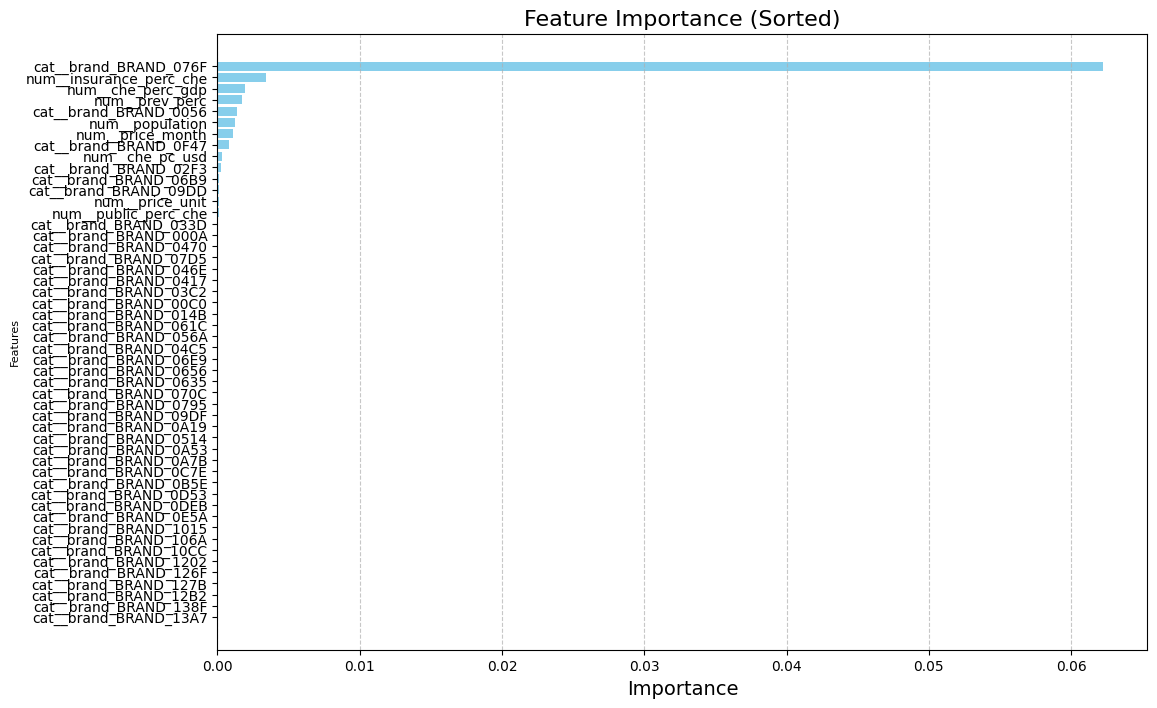

In [29]:
import matplotlib.pyplot as plt
from xgboost import plot_importance


# Extract the XGBRegressor from the pipeline
xgb_regressor = best_model.named_steps["regressor"]

# Handle feature names based on the preprocessor
preprocessor = best_model.named_steps["preprocessor"]

# Get transformed feature names
if hasattr(preprocessor, "get_feature_names_out"):
    feature_names = preprocessor.get_feature_names_out()
else:
    # If the preprocessor does not support this, use generic feature indices
    feature_names = [f"Feature_{i}" for i in range(xgb_regressor.feature_importances_.shape[0])]

# Get feature importances
importance = xgb_regressor.feature_importances_

# Create a DataFrame for sorting and visualization
importance_df = pd.DataFrame({
    "Feature": feature_names[:50],
    "Importance": importance[:50]
}).sort_values(by="Importance", ascending=False)

# Enhanced bar plot
plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=8)
plt.title("Feature Importance (Sorted)", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for highest importance at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

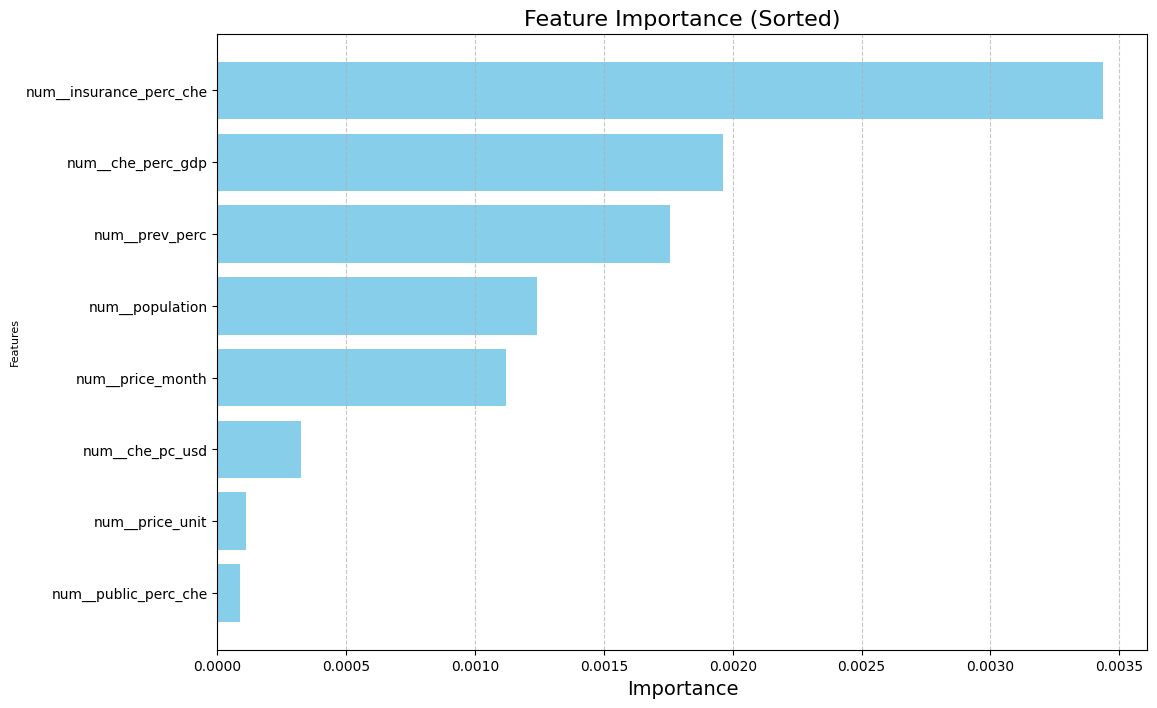

In [32]:
df_num = importance_df[importance_df.Feature.str.contains('num')]
plt.figure(figsize=(12, 8))
plt.barh(df_num["Feature"], df_num["Importance"], color="skyblue")
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=8)
plt.title("Feature Importance (Sorted)", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for highest importance at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [25]:
len(importance)

4132

In [126]:
features_test = submission_df.drop(columns=['target'])
y = submission_df['target']
date_cols = ["launch_date", "date"]  # Adjust as necessary
for col in date_cols:
    features_test[col] = pd.to_datetime(features_test[col], errors='coerce')
    features_test[f"{col}_year"] = features_test[col].dt.year
    features_test[f"{col}_month"] = features_test[col].dt.month
    features_test[f"{col}_day"] = features_test[col].dt.day
features_test.drop(columns=date_cols, inplace=True)

In [127]:
missing_cols = set(X_train.columns) - set(features_test.columns)
for col in missing_cols:
    features_test[col] = 0 

new_data = features_test[X_train.columns]
predictions = best_model.predict(new_data)

In [128]:
new_data_with_predictions = new_data.copy()
new_data_with_predictions["prediction"] = predictions
date_cols = ["date"]
for col in date_cols:
    year_col = f"{col}_year"
    month_col = f"{col}_month"
    day_col = f"{col}_day"
    
    if all(c in new_data_with_predictions.columns for c in [year_col, month_col, day_col]):
        new_data_with_predictions[col] = pd.to_datetime(
            dict(year=new_data_with_predictions[year_col], 
                 month=new_data_with_predictions[month_col], 
                 day=new_data_with_predictions[day_col]),
            errors='coerce'
        )
        # Drop the individual year, month, and day columns if necessary
        new_data_with_predictions.drop(columns=[year_col, month_col, day_col], inplace=True)

In [129]:
final_df = new_data_with_predictions.drop(columns=['brand', 'che_pc_usd', 'che_perc_gdp', 'corporation',
       'country', 'drug_id', 'ind_launch_date', 'indication',
       'insurance_perc_che', 'population', 'prev_perc', 'price_month',
       'price_unit', 'public_perc_che', 'therapeutic_area', 'launch_date_year',
       'launch_date_month', 'launch_date_day'])

In [130]:

template_df["date"] = pd.to_datetime(template_df["date"], errors="coerce")
final_df["date"] = pd.to_datetime(final_df["date"], errors="coerce")
filled_df = template_df.merge(
    final_df, 
    on=["date", "cluster_nl"], 
    how="left", 
    suffixes=("", "_pred")
)
filled_df["prediction"] = filled_df["prediction"].fillna(filled_df["prediction_pred"])
filled_df.drop(columns=["prediction_pred"], inplace=True)

In [131]:
filled_df

,date,cluster_nl,prediction
0,2023-01-01,BRAND_9259_COUNTRY_6B71,1.113032
1,2023-02-01,BRAND_9259_COUNTRY_6B71,1.062780
2,2023-03-01,BRAND_9259_COUNTRY_6B71,1.062780
3,2023-04-01,BRAND_9259_COUNTRY_6B71,1.073050
4,2023-05-01,BRAND_9259_COUNTRY_6B71,1.062780
...,...,...,...
1764,2023-08-01,BRAND_056A_COUNTRY_3536,0.986712
1765,2023-09-01,BRAND_056A_COUNTRY_3536,0.986712
1766,2023-10-01,BRAND_056A_COUNTRY_3536,0.986712
1767,2023-11-01,BRAND_056A_COUNTRY_3536,0.986712


In [132]:
template_df

,date,cluster_nl,prediction
0,2023-01-01,BRAND_9259_COUNTRY_6B71,NaN
1,2023-02-01,BRAND_9259_COUNTRY_6B71,NaN
2,2023-03-01,BRAND_9259_COUNTRY_6B71,NaN
3,2023-04-01,BRAND_9259_COUNTRY_6B71,NaN
4,2023-05-01,BRAND_9259_COUNTRY_6B71,NaN
...,...,...,...
1764,2023-08-01,BRAND_056A_COUNTRY_3536,NaN
1765,2023-09-01,BRAND_056A_COUNTRY_3536,NaN
1766,2023-10-01,BRAND_056A_COUNTRY_3536,NaN
1767,2023-11-01,BRAND_056A_COUNTRY_3536,NaN


In [134]:
filled_df.to_csv('../data/outputs/try1.csv',index=False)